In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go  # pip install plotly
import time
import pandas as pd
import torch
from easyGPR_helper import set_gpytorch_settings, GPRModel
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
from easyGPR_helper import set_gpytorch_settings, GPRModel
from gpytorch.kernels import Kernel, ScaleKernel, PolynomialKernel, PeriodicKernel, RBFKernel
from gpytorch.kernels import CosineKernel, MaternKernel, LinearKernel
from custom_kernels import RBFNonSeparableKernel

In [2]:
#Load the data 
df = pd.read_csv('dataset-72001.csv')

x_train = torch.tensor(df['times'].values, dtype=torch.float32).unsqueeze(1)  
y_train = torch.tensor(df['accel'].values, dtype=torch.float32)        

In [3]:
#RBF Kernel since dataset is relatively smooth
k1 = ScaleKernel(RBFKernel())
m1 = GPRModel(train_x=x_train, train_y=y_train, kernel=k1, scale_x = False) 
m1.fit_model(training_iterations=1000, lr=0.1)

#Combined Kernel: RBF + Linear
k2 = ScaleKernel(RBFKernel()) + ScaleKernel(LinearKernel())
m2 = GPRModel(train_x=x_train, train_y=y_train, kernel=k2, scale_x = False) 
m2.fit_model(training_iterations=1000, lr=0.1)

#Matern Kernel + RBF
k3 = ScaleKernel(RBFKernel()) + ScaleKernel(MaternKernel(nu=2.5))
m3 = GPRModel(train_x=x_train, train_y=y_train, kernel=k3, scale_x = False) 
m3.fit_model(training_iterations=1000, lr=0.1)

Fitting complete.
--- 
--- final mll: -24.1471
--- num_params: 4
--- BIC: 3219.8059
Fitting complete.
--- 
--- final mll: -23.9939
--- num_params: 6
--- BIC: 3204.3098
Fitting complete.
--- 
--- final mll: -18.4791
--- num_params: 6
--- BIC: 2471.3066


GPRModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ConstantMean()
  (kernel): AdditiveKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
      (1): ScaleKernel(
        (base_kernel): MaternKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
    )
  )
)

In [4]:
class SincModulatedKernel(Kernel):
    def __init__(self, base_kernel=None, mu=27.5, ell=12.0):
        super().__init__()
        self.mu = mu
        self.ell = ell
        self.base_kernel = base_kernel or PeriodicKernel()

    def forward(self, x1, x2, diag=False, **params):
        f1 = sinc_envelope(x1, mu=self.mu, ell=self.ell)
        f2 = sinc_envelope(x2, mu=self.mu, ell=self.ell)

        base = self.base_kernel(x1, x2, diag=diag, **params)

        if diag:
            return base * f1
        else:
            return base * f1.unsqueeze(1) * f2.unsqueeze(0)

In [5]:
def sinc_envelope(x, mu=27.5, ell=12.0):
    z = (x.squeeze(-1) - mu) / ell
    pi_z = torch.pi * z
    sinc = torch.where(pi_z == 0, torch.ones_like(pi_z), torch.sin(pi_z) / pi_z)
    #apply a sigmoidal function increase for variance increase
    return sinc * (1.0 + 60 * torch.sigmoid((x.squeeze(-1) - 35) / 4))

In [6]:
# Custom Kernel - Sinc * Sine 
periodic = PeriodicKernel()
periodic.period_length = 25.0 #Set period to 25
custom_kernel = periodic*MaternKernel(nu=2.5) + ScaleKernel(RBFKernel())

k4 = ScaleKernel(SincModulatedKernel(base_kernel=custom_kernel, mu=27.5, ell=13)) + ScaleKernel(RBFKernel())
m4 = GPRModel(train_x=x_train, train_y=y_train, kernel=k4, scale_x = False) 
m4.fit_model(training_iterations=1000, lr=0.1)

Fitting complete.
--- 
--- final mll: -11.5701
--- num_params: 10
--- BIC: 1562.6569


GPRModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ConstantMean()
  (kernel): AdditiveKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): SincModulatedKernel(
          (base_kernel): AdditiveKernel(
            (kernels): ModuleList(
              (0): ProductKernel(
                (kernels): ModuleList(
                  (0): PeriodicKernel(
                    (raw_lengthscale_constraint): Positive()
                    (raw_period_length_constraint): Positive()
                  )
                  (1): MaternKernel(
                    (raw_lengthscale_constraint): Positive()
                  )
                )
              )
              (1): ScaleKernel(
                (base_kernel): RBFKernel(
                  (raw_lengthscale_constraint): Positive()
                )
                (raw_outputscale_constraint): Positive()
              )
 

In [7]:
display(m1.get_hyperparameters_df())
display(m2.get_hyperparameters_df())
display(m3.get_hyperparameters_df())
display(m4.get_hyperparameters_df())

,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,14.197755
1,mean_module.constant,-11.787145
2,kernel.outputscale,10.199713
3,kernel.base_kernel.lengthscale,3.432467


,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,14.184437
1,mean_module.constant,-17.688515
2,kernel.kernels.0.outputscale,10.286782
3,kernel.kernels.0.base_kernel.lengthscale,3.387750
4,kernel.kernels.1.outputscale,0.253135
5,kernel.kernels.1.base_kernel.variance,0.253121


,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,12.149395
1,mean_module.constant,-12.355470
2,kernel.kernels.0.outputscale,14.129745
3,kernel.kernels.0.base_kernel.lengthscale,3.593157
4,kernel.kernels.1.outputscale,12.679851
5,kernel.kernels.1.base_kernel.lengthscale,0.039543


,Hyperparameter Name,Estimate
0,likelihood.noise_covar.noise,13.485956
1,mean_module.constant,-12.876316
2,kernel.kernels.0.outputscale,9.139743
3,kernel.kernels.0.base_kernel.base_kernel.kerne...,0.284124
4,kernel.kernels.0.base_kernel.base_kernel.kerne...,23.778582
5,kernel.kernels.0.base_kernel.base_kernel.kerne...,0.043638
6,kernel.kernels.0.base_kernel.base_kernel.kerne...,10.871365
7,kernel.kernels.0.base_kernel.base_kernel.kerne...,4.372247
8,kernel.kernels.1.outputscale,6.657840
9,kernel.kernels.1.base_kernel.lengthscale,0.626865


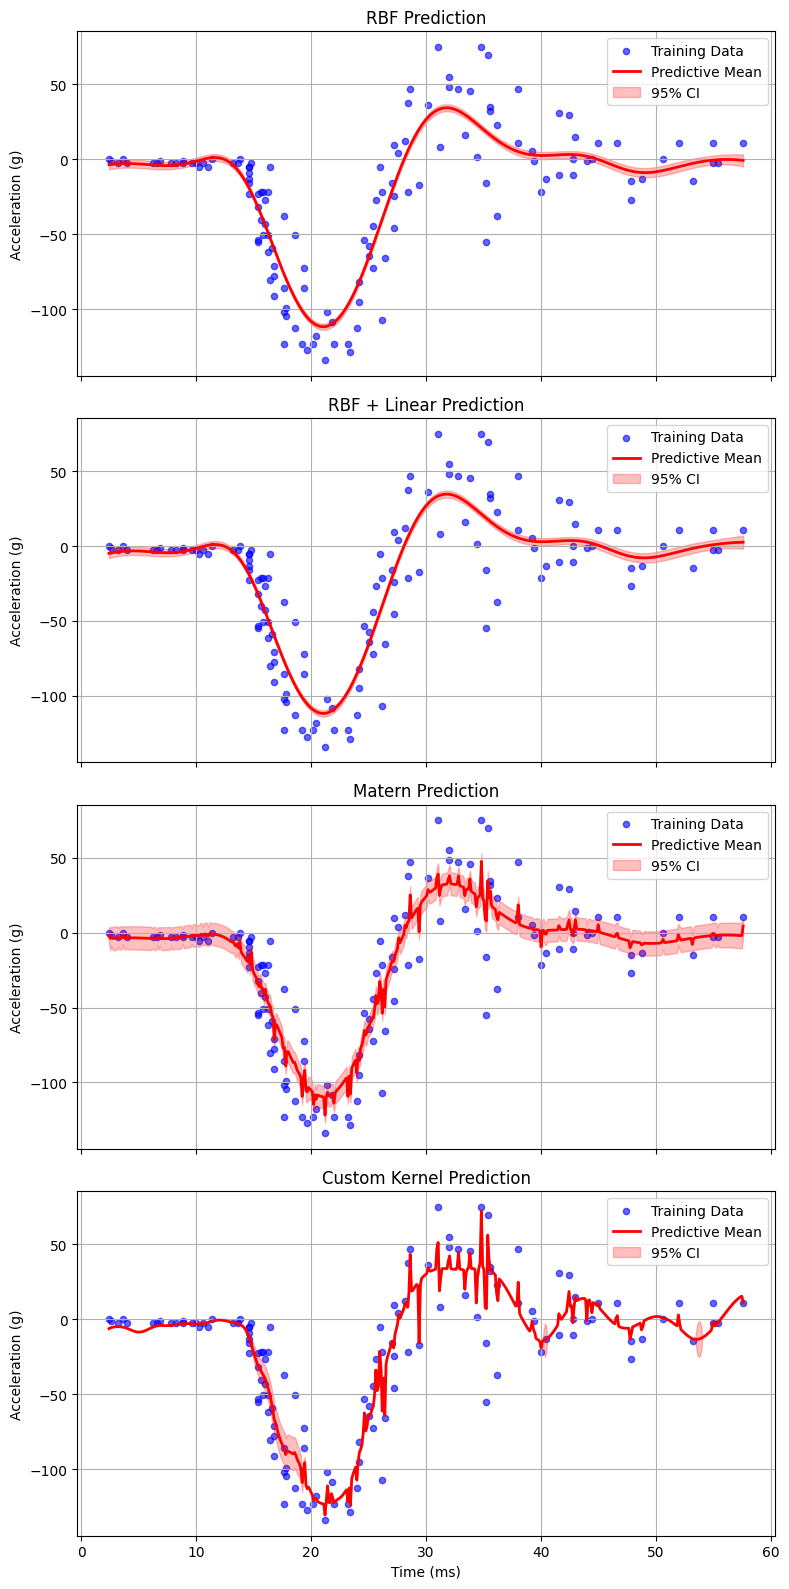

In [9]:
x_min_eval, x_max_eval = df['times'].min(), df['times'].max()
n_x_eval = 500
x_eval = np.linspace(x_min_eval, x_max_eval, n_x_eval).reshape(-1, 1)

# Predictions
predictions_m1 = m1.make_predictions(x_eval, return_type="numpy")
predictions_m2 = m2.make_predictions(x_eval, return_type="numpy")
predictions_m3 = m3.make_predictions(x_eval, return_type="numpy")
predictions_m4 = m4.make_predictions(x_eval, return_type="numpy")

models = [
    ('RBF', predictions_m1),
    ('RBF + Linear', predictions_m2),
    ('Matern', predictions_m3),
    ('Custom Kernel', predictions_m4)
]

fig, axes = plt.subplots(len(models), 1, figsize=(8, 4 * len(models)), sharex=True)

if len(models) == 1:
    axes = [axes]

for row, (model_name, pred) in enumerate(models):
    mean = pred.mean.flatten()
    std_dev = np.sqrt(pred.variance.flatten())
    
    lower = mean - 1.96 * std_dev
    upper = mean + 1.96 * std_dev

    ax = axes[row]
    ax.scatter(df['times'], df['accel'], color='blue', label="Training Data", s=20, alpha=0.6)
    ax.plot(x_eval.flatten(), mean, color='red', lw=2, label="Predictive Mean")
    ax.fill_between(x_eval.flatten(), lower, upper, color='red', alpha=0.25, label="95% CI")

    ax.set_title(f'{model_name} Prediction')
    ax.set_ylabel('Acceleration (g)')
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()
